# Player Embedding Training

Train a SoccerMap model with learnable player embeddings.  
After training, extract embeddings for player-similarity analysis.

**Pipeline:**
1. Load multi-match data (Leverkusen 2023/24 Bundesliga)
2. Build global player-ID mapping
3. Expand events with actor identity
4. Create `PassDatasetWithIdentity` per match
5. Train pass-selection model
6. Evaluate & visualize
7. Player similarity analysis

## 1. Setup

In [1]:
import sys, os
from pathlib import Path

sys.dont_write_bytecode = True
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Find project root
p = Path.cwd()
for _ in range(10):
    if (p / "environment.yml").exists() or (p / "README.md").exists():
        PROJECT_ROOT = p
        break
    p = p.parent
else:
    raise RuntimeError("Cannot find project root.")

CODE_DIR = PROJECT_ROOT / "code"
TED_DIR = PROJECT_ROOT / "notebooks" / "sandbox" / "ted"

for d in [str(CODE_DIR), str(TED_DIR)]:
    if d not in sys.path:
        sys.path.insert(0, d)

DATA_ROOT = PROJECT_ROOT / "data" / "leverkusen_data"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CODE_DIR:    ", CODE_DIR)
print("DATA_ROOT:   ", DATA_ROOT)

PROJECT_ROOT: d:\Player-decision-simulation
CODE_DIR:     d:\Player-decision-simulation\code
DATA_ROOT:    d:\Player-decision-simulation\data\leverkusen_data


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

from player_embedding import (
    load_match_data,
    build_events_dataframe,
    load_lineup_dataframe,
    find_matches_with_360,
    find_seasons_for_competition,
    load_team_matches,
    build_player_id_mapping,
    build_expanded_dfs_with_identity,
    PassDatasetWithIdentity,
    SoccerMapWithEmbedding,
    pass_selection_loss,
    pass_success_loss,
    pass_selection_surface,
    pass_success_surface,
    GridSpec,
)

print("All imports OK")

All imports OK


## 2. Discover matches

In [3]:
TEAM_NAME = "Bayer Leverkusen"
COMPETITION_ID = 9  # Bundesliga

seasons = find_seasons_for_competition(COMPETITION_ID, base_dir=str(DATA_ROOT))
# pick the season with 360 data
cand = [s for s in seasons if s.get("match_available_360") not in [None, False, "None"]]
SEASON_ID = cand[0]["season_id"] if cand else seasons[0]["season_id"]
print(f"Season: {SEASON_ID}")

matches = load_team_matches(
    team_name=TEAM_NAME,
    competition_id=COMPETITION_ID,
    season_id=SEASON_ID,
    base_dir=str(DATA_ROOT),
)
match_ids_360 = find_matches_with_360(matches, base_dir=str(DATA_ROOT))
print(f"Matches with 360 data: {len(match_ids_360)}")
print(f"First 5: {match_ids_360[:5]}")

Season: 281
Matches with 360 data: 34
First 5: [3895302, 3895292, 3895333, 3895340, 3895348]


## 3. Load data & build global player mapping

We load all matches to build a single player-ID mapping,  
then hold out the last match for validation.

In [4]:
# How many matches to use (set to len(match_ids_360) for full training)
MAX_MATCHES = 5  # start small for quick iteration
HOLDOUT = 1       # number of matches reserved for validation

selected_ids = match_ids_360[:MAX_MATCHES]
train_ids = selected_ids[:-HOLDOUT]
val_ids = selected_ids[-HOLDOUT:]

print(f"Train matches: {len(train_ids)} -> {train_ids}")
print(f"Val matches:   {len(val_ids)}   -> {val_ids}")

Train matches: 4 -> [3895302, 3895292, 3895333, 3895340]
Val matches:   1   -> [3895348]


In [5]:
# Load combined events + lineups for ALL selected matches
all_combined = {}   # match_id -> combined list
all_lineups = {}    # match_id -> lineup_df
all_events_df = {}  # match_id -> events_df

for mid in selected_ids:
    combined = load_match_data(mid, base_dir=str(DATA_ROOT))
    lineup_df = load_lineup_dataframe(mid, base_dir=str(DATA_ROOT))
    events_df = build_events_dataframe(combined)
    all_combined[mid] = combined
    all_lineups[mid] = lineup_df
    all_events_df[mid] = events_df
    print(f"  match {mid}: {len(combined)} events, {len(lineup_df)} players in lineup")

print(f"\nLoaded {len(selected_ids)} matches")

  match 3895302: 4223 events, 38 players in lineup
  match 3895292: 3843 events, 40 players in lineup
  match 3895333: 3549 events, 40 players in lineup
  match 3895340: 3315 events, 40 players in lineup
  match 3895348: 4133 events, 39 players in lineup

Loaded 5 matches


In [6]:
# Build global mapping across ALL matches (train + val)
merged_events = pd.concat(all_events_df.values(), ignore_index=True)
merged_lineups = pd.concat(all_lineups.values(), ignore_index=True)

player_mapping = build_player_id_mapping(merged_events, merged_lineups)
num_players = len(player_mapping)

print(f"Global player mapping: {num_players} players (indices 1..{num_players}, 0=padding)")
print(f"Sample: {dict(list(player_mapping.items())[:5])}")

Global player mapping: 119 players (indices 1..119, 0=padding)
Sample: {'Adam Hložek': 1, 'Alejandro Grimaldo García': 2, 'Alex Král': 3, 'Alexander Schwolow': 4, 'Amine Adli': 5}


## 4. Build datasets

In [7]:
def build_dataset_for_match(match_id, compute_velocities=False):
    """Expand + create PassDatasetWithIdentity for one match."""
    em = build_expanded_dfs_with_identity(
        all_combined[match_id],
        all_lineups[match_id],
        player_mapping,
    )
    ds = PassDatasetWithIdentity(
        em.expanded_df,
        only_passes=True,
        compute_velocities=compute_velocities,
    )
    return ds, em


# Build train datasets
train_datasets = []
for mid in train_ids:
    ds, _ = build_dataset_for_match(mid)
    train_datasets.append(ds)
    print(f"  train match {mid}: {len(ds)} pass samples")

train_ds = ConcatDataset(train_datasets)
print(f"Total training samples: {len(train_ds)}")

# Build val datasets
val_datasets = []
val_expanded = {}  # keep for visualization later
for mid in val_ids:
    ds, em = build_dataset_for_match(mid)
    val_datasets.append(ds)
    val_expanded[mid] = em
    print(f"  val match {mid}: {len(ds)} pass samples")

val_ds = ConcatDataset(val_datasets)
print(f"Total validation samples: {len(val_ds)}")

  train match 3895302: 952 pass samples
  train match 3895292: 875 pass samples
  train match 3895333: 837 pass samples
  train match 3895340: 789 pass samples
Total training samples: 3453
  val match 3895348: 1029 pass samples
Total validation samples: 1029


In [8]:
# Free intermediate data no longer needed (save RAM)
import gc

del all_combined, all_events_df, all_lineups
del merged_events, merged_lineups
gc.collect()

if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Freed intermediate data.")

Freed intermediate data.


## 5. Training

In [9]:
# Hyperparameters
EMBED_DIM = 8
EPOCHS = 10
BATCH_SIZE = 16
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"Embed dim: {EMBED_DIM}")
print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}, LR: {LR}")

Device: cuda
GPU: NVIDIA GeForce RTX 3080
VRAM: 10.0 GB
Embed dim: 8
Epochs: 10, Batch size: 16, LR: 0.001


In [10]:
def collate_fn(batch):
    """Collate PassSampleWithIdentity into batched tensors."""
    channels = torch.stack([s.channels for s in batch])
    actor_ids = torch.tensor([s.actor_id for s in batch], dtype=torch.long)
    dest_indices = torch.tensor([s.dest_index for s in batch], dtype=torch.long)
    completed = torch.tensor(
        [s.completed if s.completed is not None else -1 for s in batch],
        dtype=torch.float32,
    )
    return channels, actor_ids, dest_indices, completed


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn)

print(f"Train batches: {len(train_dl)}, Val batches: {len(val_dl)}")

Train batches: 216, Val batches: 65


In [11]:
model = SoccerMapWithEmbedding(
    num_players=num_players,
    embed_dim=EMBED_DIM,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

total_params = sum(p.numel() for p in model.parameters())
embed_params = sum(p.numel() for p in model.player_embedding.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Embedding parameters: {embed_params:,} ({100*embed_params/total_params:.1f}%)")

Total parameters: 151,243
Embedding parameters: 960 (0.6%)


In [12]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    epoch_loss = 0.0
    n_samples = 0

    for channels, actor_ids, dest_indices, completed in train_dl:
        channels = channels.to(DEVICE)
        actor_ids = actor_ids.to(DEVICE)
        dest_indices = dest_indices.to(DEVICE)

        logits = model(channels, actor_ids)
        loss = pass_selection_loss(logits, dest_indices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * len(channels)
        n_samples += len(channels)

    avg_train = epoch_loss / max(n_samples, 1)
    train_losses.append(avg_train)

    # --- Val ---
    model.eval()
    val_loss = 0.0
    val_n = 0
    with torch.no_grad():
        for channels, actor_ids, dest_indices, completed in val_dl:
            channels = channels.to(DEVICE)
            actor_ids = actor_ids.to(DEVICE)
            dest_indices = dest_indices.to(DEVICE)

            logits = model(channels, actor_ids)
            loss = pass_selection_loss(logits, dest_indices)

            val_loss += loss.item() * len(channels)
            val_n += len(channels)

    avg_val = val_loss / max(val_n, 1)
    val_losses.append(avg_val)

    # GPU memory info
    gpu_info = ""
    if DEVICE == "cuda":
        alloc = torch.cuda.memory_allocated() / 1024**2
        reserved = torch.cuda.memory_reserved() / 1024**2
        gpu_info = f"  GPU: {alloc:.0f}/{reserved:.0f} MB (alloc/reserved)"
        torch.cuda.empty_cache()

    print(f"Epoch {epoch+1}/{EPOCHS}  train_loss={avg_train:.4f}  val_loss={avg_val:.4f}{gpu_info}")

print("\nTraining complete.")

Epoch 1/10  train_loss=8.1095  val_loss=7.8979  GPU: 5/368 MB (alloc/reserved)
Epoch 2/10  train_loss=8.0238  val_loss=7.9133  GPU: 5/368 MB (alloc/reserved)
Epoch 3/10  train_loss=7.9660  val_loss=7.7412  GPU: 5/368 MB (alloc/reserved)
Epoch 4/10  train_loss=7.7936  val_loss=7.6118  GPU: 5/368 MB (alloc/reserved)
Epoch 5/10  train_loss=7.6468  val_loss=7.3047  GPU: 5/368 MB (alloc/reserved)
Epoch 6/10  train_loss=7.5787  val_loss=7.2880  GPU: 5/368 MB (alloc/reserved)
Epoch 7/10  train_loss=7.5791  val_loss=7.2715  GPU: 5/368 MB (alloc/reserved)
Epoch 8/10  train_loss=7.5419  val_loss=7.2838  GPU: 5/368 MB (alloc/reserved)
Epoch 9/10  train_loss=7.4457  val_loss=7.1758  GPU: 5/368 MB (alloc/reserved)
Epoch 10/10  train_loss=7.3410  val_loss=7.0521  GPU: 5/368 MB (alloc/reserved)

Training complete.


## 6. Training curves

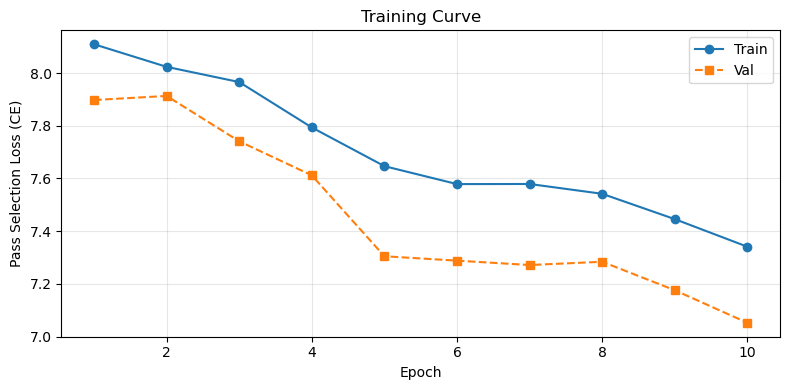

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, EPOCHS + 1), train_losses, "o-", label="Train")
ax.plot(range(1, EPOCHS + 1), val_losses, "s--", label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Pass Selection Loss (CE)")
ax.set_title("Training Curve")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Evaluation on validation set

In [14]:
# Top-K accuracy: is the true destination in the top-K predicted pixels?
model.eval()
grid = GridSpec()

top_k_values = [1, 5, 10, 50, 100]
correct = {k: 0 for k in top_k_values}
total = 0

with torch.no_grad():
    for channels, actor_ids, dest_indices, completed in val_dl:
        channels = channels.to(DEVICE)
        actor_ids = actor_ids.to(DEVICE)
        logits = model(channels, actor_ids)

        N = logits.shape[0]
        flat = logits.view(N, -1)  # (N, L*W)

        for k in top_k_values:
            _, topk_idx = flat.topk(k, dim=1)
            hits = (topk_idx == dest_indices.unsqueeze(1).to(DEVICE)).any(dim=1)
            correct[k] += hits.sum().item()

        total += N

print(f"Validation samples: {total}")
print("-" * 35)
for k in top_k_values:
    acc = correct[k] / max(total, 1) * 100
    print(f"  Top-{k:>3d} accuracy: {acc:6.2f}%")

Validation samples: 1029
-----------------------------------
  Top-  1 accuracy:   1.07%
  Top-  5 accuracy:   5.15%
  Top- 10 accuracy:   9.62%
  Top- 50 accuracy:  33.14%
  Top-100 accuracy:  45.97%


## 8. Player Similarity Analysis

In [15]:
# Build reverse mapping: index -> name
idx_to_name = {v: k for k, v in player_mapping.items()}

# Get similarity matrix (excludes padding index 0)
sim_matrix = model.get_similarity_matrix(exclude_padding=True)
player_names = [idx_to_name[i] for i in range(1, num_players + 1)]

print(f"Similarity matrix shape: {sim_matrix.shape}")
print(f"Players: {len(player_names)}")

Similarity matrix shape: (119, 119)
Players: 119


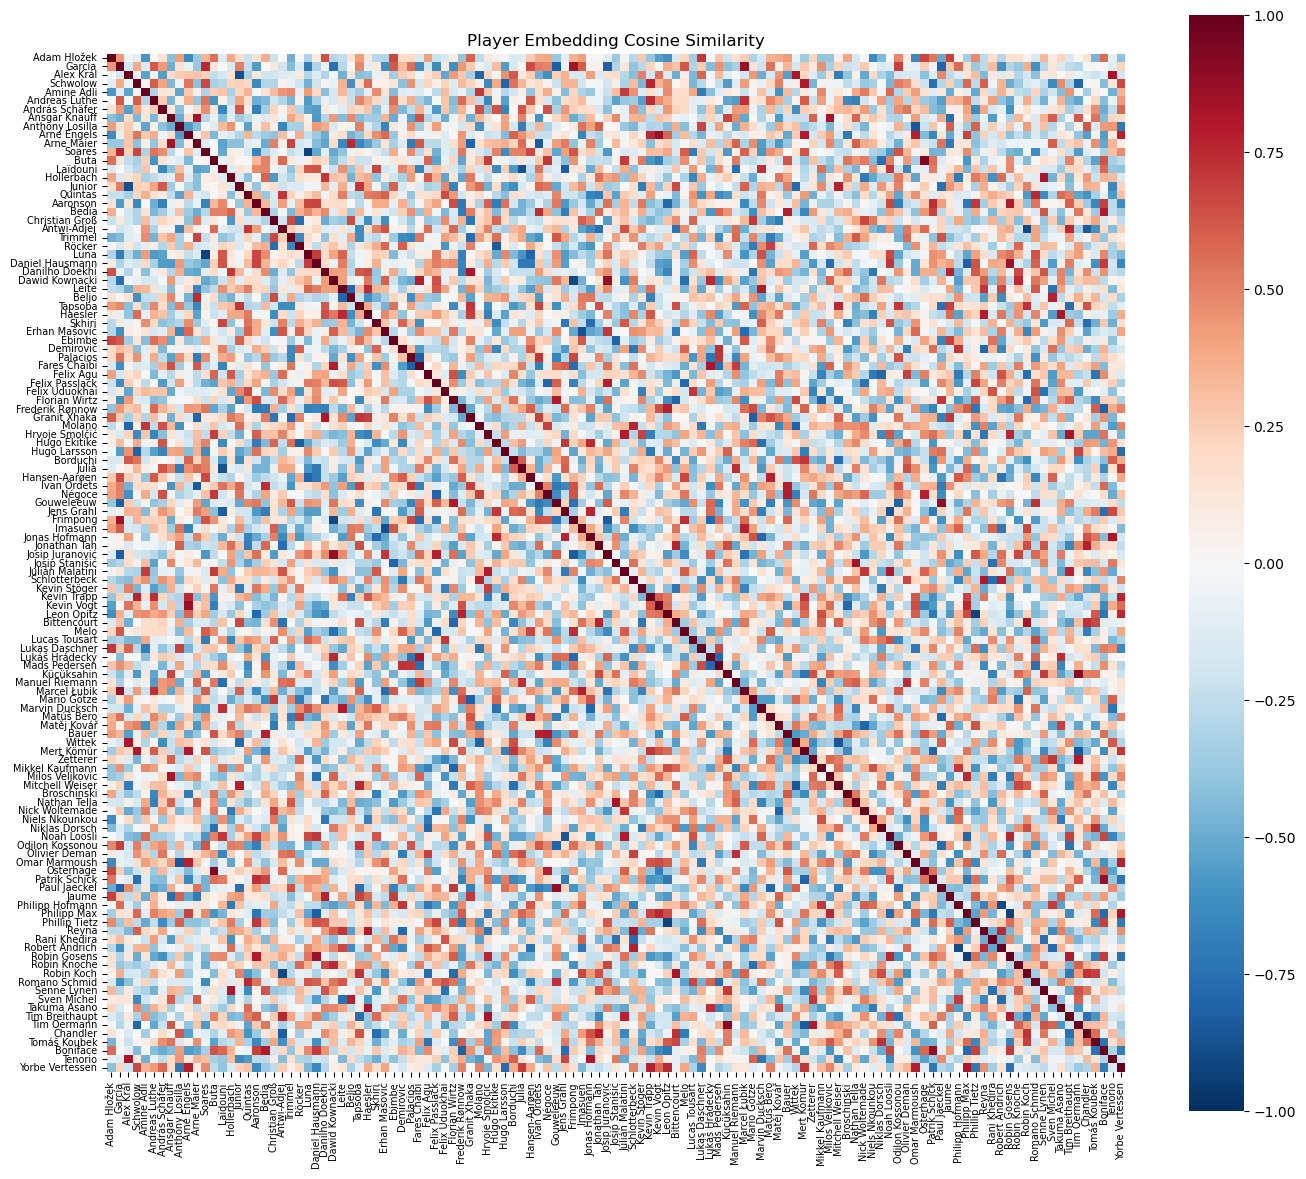

In [16]:
# Heatmap of player similarity
# Use short names for readability
short_names = [n.split()[-1] if len(n) > 15 else n for n in player_names]

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    sim_matrix,
    xticklabels=short_names,
    yticklabels=short_names,
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    ax=ax,
)
ax.set_title("Player Embedding Cosine Similarity")
plt.xticks(rotation=90, fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()
plt.show()

In [17]:
# Top most-similar and most-different player pairs
pairs = []
for i in range(len(player_names)):
    for j in range(i + 1, len(player_names)):
        pairs.append((player_names[i], player_names[j], sim_matrix[i, j]))

pairs.sort(key=lambda x: x[2], reverse=True)

print("Top 10 most SIMILAR player pairs:")
for a, b, s in pairs[:10]:
    print(f"  {s:+.4f}  {a}  <->  {b}")

print("\nTop 10 most DIFFERENT player pairs:")
for a, b, s in pairs[-10:]:
    print(f"  {s:+.4f}  {a}  <->  {b}")

Top 10 most SIMILAR player pairs:
  +0.9348  Aurélio Gabriel Ulineia Buta  <->  Patrick Osterhage
  +0.9086  Mahmut Kücüksahin  <->  Tim Oermann
  +0.8871  Jeffrey Gouweleeuw  <->  Paul Jaeckel
  +0.8767  Dawid Kownacki  <->  Josip Juranović
  +0.8685  Patrik Schick  <->  Victor Okoh Boniface
  +0.8656  Alejandro Grimaldo García  <->  Marcel Łubik
  +0.8612  Arne Engels  <->  Kevin Vogt
  +0.8521  Daniel Hausmann  <->  Robin Gosens
  +0.8360  Alejandro Grimaldo García  <->  Jeremie Frimpong
  +0.8294  Ansgar Knauff  <->  Arne Maier

Top 10 most DIFFERENT player pairs:
  -0.8578  Jens Grahl  <->  Noah Loosli
  -0.8693  Aïssa Bilal Laïdouni  <->  Ignacio Ferri Julià
  -0.8773  Erhan Mašović  <->  Joel Victor Imasuen
  -0.8814  Alex Král  <->  Bernardo Fernandes da Silva Junior
  -0.8940  Philipp Hofmann  <->  Robert Andrich
  -0.8994  Christopher Antwi-Adjej  <->  Robin Koch
  -0.9036  Dawid Kownacki  <->  Jeremie Frimpong
  -0.9292  Leon Opitz  <->  Phillip Tietz
  -0.9350  Arthur Augus

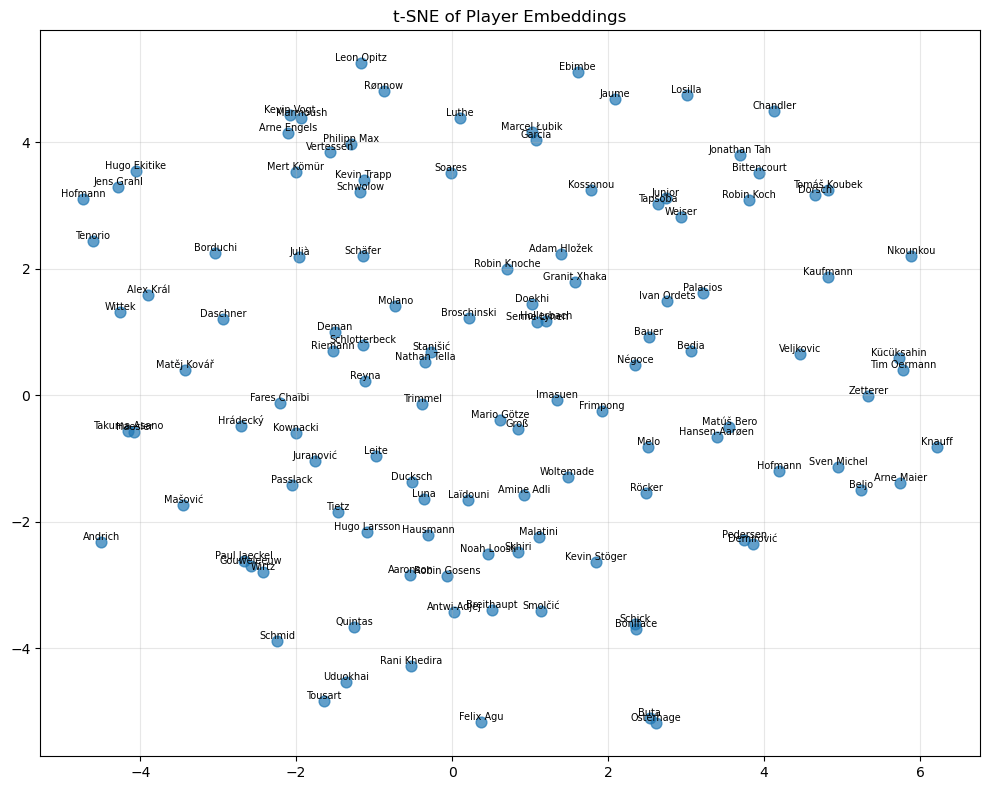

In [18]:
from sklearn.manifold import TSNE

embeddings = model.get_player_embeddings()[1:]  # skip padding

# Determine perplexity: must be < n_samples
n = embeddings.shape[0]
perp = min(30, max(2, n - 1))

tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
coords = tsne.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(coords[:, 0], coords[:, 1], s=60, alpha=0.7)

for i, name in enumerate(player_names):
    short = name.split()[-1] if len(name) > 12 else name
    ax.annotate(short, (coords[i, 0], coords[i, 1]),
                fontsize=7, ha="center", va="bottom")

ax.set_title("t-SNE of Player Embeddings")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Save checkpoint

In [19]:
ckpt_dir = PROJECT_ROOT / "checkpoints"
ckpt_dir.mkdir(exist_ok=True)

ckpt_path = ckpt_dir / "player_embedding_pass_selection.pt"
torch.save({
    "model_state": model.state_dict(),
    "player_mapping": player_mapping,
    "num_players": num_players,
    "embed_dim": EMBED_DIM,
    "train_ids": train_ids,
    "val_ids": val_ids,
    "train_losses": train_losses,
    "val_losses": val_losses,
}, ckpt_path)

print(f"Checkpoint saved: {ckpt_path}")

Checkpoint saved: d:\Player-decision-simulation\checkpoints\player_embedding_pass_selection.pt


## 10. Visualize pass-selection surface for a sample

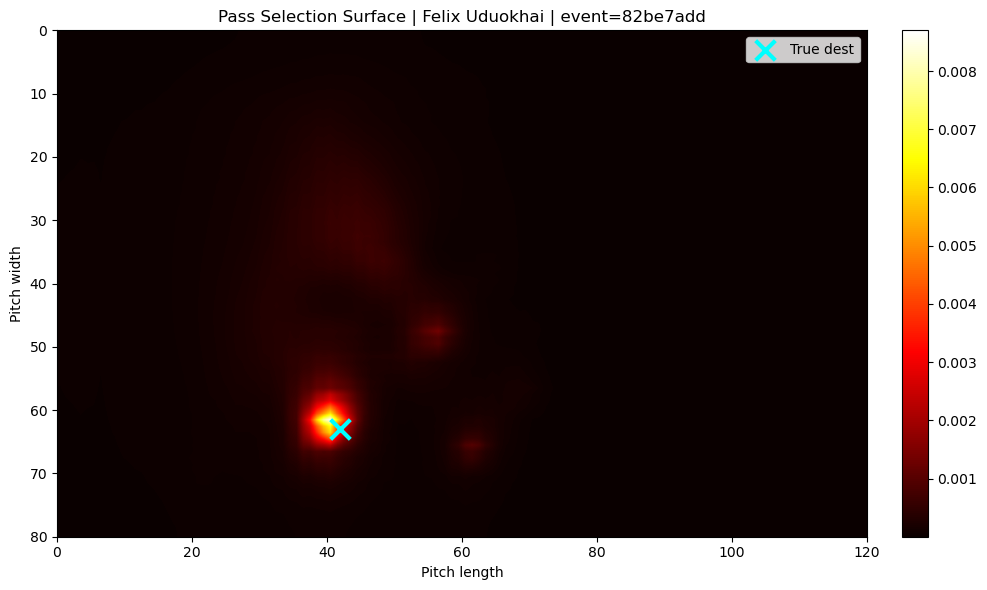

In [20]:
# Pick a sample from val set
sample = val_ds[0]

model.eval()
with torch.no_grad():
    x = sample.channels.unsqueeze(0).to(DEVICE)
    ids = torch.tensor([sample.actor_id], dtype=torch.long, device=DEVICE)
    logits = model(x, ids)
    surf = pass_selection_surface(logits)[0].cpu().numpy()  # (120, 80)

player_name = idx_to_name.get(sample.actor_id, "Unknown")

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    surf.T,  # (W, L) for display
    extent=[0, 120, 80, 0],
    aspect="auto",
    cmap="hot",
    interpolation="bilinear",
)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Mark true destination
dl, dw = sample.dest_lw
ax.scatter([dl], [dw], marker="x", s=200, c="cyan", linewidths=3, label="True dest")

ax.set_title(f"Pass Selection Surface | {player_name} | event={sample.event_id[:8]}")
ax.set_xlabel("Pitch length")
ax.set_ylabel("Pitch width")
ax.legend()
plt.tight_layout()
plt.show()